# Load packages

In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Load data

In [2]:
#Creating decision tree model with combined + cleaned dataset: train_merge_all.csv, test_merge_all.csv
train = pd.read_csv('../datasets/train_merge_all.csv')
test = pd.read_csv('../datasets/test_merge_all.csv')

train = train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)
test = test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)

In [79]:
#check train + test set variable sets: these do not include target Y = WnvPresent (0/1)
print(train.shape, test.shape)
print('\n')
print(train.columns, '\n\n', test.columns)

(10506, 28) (116293, 28)


Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DaysFromSpray', 'LogDays', 'SprayEffect'],
      dtype='object') 

 Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DaysFromSpray', 'LogDays', 'SprayEffect'],
      dtype='object')


In [81]:
#Set X (variable) and y (target) datasets for training data
X = train

y = pd.read_csv('target.csv')
y.head()

print(X.shape, y.shape)

(10506, 28) (10506, 1)


In [82]:
#Set baseline accuracy
print(y['WnvPresent'].value_counts())
baseline = y['WnvPresent'].value_counts() / len(y)
print(baseline)

0    9955
1     551
Name: WnvPresent, dtype: int64
0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64


# Preprocess data

In [8]:
#function to prepare dataset for modeling

def process_features(df, drop_cols):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = pd.to_numeric(df['Date'])
    df.drop(columns = drop_cols, inplace = True)
    df = pd.get_dummies(df, columns = ['Species'])
    
    # create dummies for weather codes
    
    # replace str object with list
    df['CodeSum'] = df['CodeSum'].map(lambda x: re.findall(r'([A-Z\+\-]+)', x))
    
    # find all unique codes in the dataframe
    codes = []
    for value in df['CodeSum'].values:
        codes.extend(value)  
    codes = set(codes)
    
    # add dummy flags for each unique code
    for code in codes:
        df[code] = df['CodeSum'].map(lambda x: 1 if code in x else 0)
        
    df.drop(columns='CodeSum', inplace = True)
        
    return df

#replaced
#turn text features (col CodeSum from weather data) into categories
#train = pd.get_dummies(train)
#train.head()

#test = pd.get_dummies(test)
#test.head()

In [9]:
#train
X = process_features(X, drop_cols = ['Date', 'Trap'])

#test
test = process_features(test, drop_cols = ['Date', 'Trap'])

In [10]:
test.head()
train.head()

,Species,Longitude,Latitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,DaysFromSpray,LogDays,SprayEffect
0,CULEX PIPIENS/RESTUANS,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
1,CULEX RESTUANS,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
2,CULEX RESTUANS,-87.769279,41.994991,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
3,CULEX PIPIENS/RESTUANS,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
4,CULEX RESTUANS,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,57.8,1.3,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0


In [11]:
#train-test-split training set: 75/25 split, stratify y to preseve distro
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7879, 46) (7879, 1)
(2627, 46) (2627, 1)


In [12]:
#standard scale
ss = StandardScaler()
ss.fit_transform(X_train)
ss.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
#balance classes in X_train (training set of training set)

import numpy as np
C0_ratio = 2/3
C1_ratio = 1 - C0_ratio
Total = len(y_train['WnvPresent'])

#from class 0 observations, random sample 5253
    #rows from X_train that are class 0
X_train_C0_rows = [i for i in X_train[y_train['WnvPresent'] == 0].index]
X_train_C0_undersample = np.random.choice(X_train_C0_rows, int(round(C0_ratio*Total, 0)), replace = False)
X_train_C0_undersample = list(X_train_C0_undersample)

#from class 1 observations, random sample 2626
    #rows from X_train that are class 1
X_train_C1_rows = [i for i in X_train[y_train['WnvPresent'] == 1].index]
X_train_C1_oversample = np.random.choice(X_train_C1_rows, int(round(C1_ratio*Total, 0)), replace = True)
X_train_C1_oversample = list(X_train_C1_oversample)

#reset X_train and y_train
X_train_balanced = X_train_C0_undersample + X_train_C1_oversample
X_train = X_train.loc[X_train_balanced, :]
y_train = y_train.loc[X_train_balanced, :]

In [14]:
#checker
y_train['WnvPresent'].value_counts()
X_train.head()

,Longitude,Latitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SQ,MIFG,VCFG,HZ,BCFG,DZ,GR,FU,FG+,FG
9038,-87.654224,41.867108,87.0,69.9,78.6,3.7,63.1,68.7,0.0,13.6,...,0,0,0,0,0,0,0,0,0,0
8347,-87.785288,41.923738,80.2,59.4,70.0,0.4,54.9,61.1,0.2,5.2,...,0,0,0,1,0,0,0,0,0,0
6237,-87.832763,41.944869,80.2,64.3,72.5,1.9,63.7,66.8,0.0,7.5,...,1,0,0,0,0,0,0,0,0,0
4697,-87.546587,41.740641,79.7,62.2,71.1,-2.7,56.6,62.7,0.1,6.3,...,0,0,0,1,0,0,0,0,0,0
7719,-87.800515,41.916265,72.6,56.9,64.9,-2.3,53.1,58.2,1.8,1.7,...,0,0,0,0,0,1,0,0,1,0


In [28]:
X_train.columns

Index(['Longitude', 'Latitude', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'DaysFromSpray', 'LogDays', 'SprayEffect',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'VCTS', 'TS', 'TSRA', 'BR', 'RA', 'SQ',
       'MIFG', 'VCFG', 'HZ', 'BCFG', 'DZ', 'GR', 'FU', 'FG+', 'FG'],
      dtype='object')

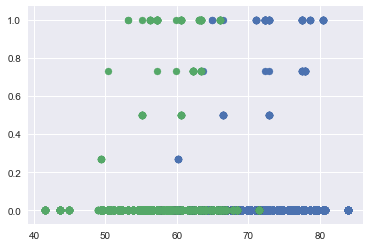

In [38]:
#sns.boxplot(X_train.groupby(['Tavg'])['SprayEffect'].mean());
plt.scatter(X_train['Tavg'], X_train['SprayEffect']);
#plt.scatter(X_train['DewPoint'], X_train['SprayEffect']);

# Model data

In [15]:
#instantiate, fit + score Decision Tree classifier
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train['WnvPresent'])
print('train:', 'acc:', tree.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], tree.predict(X_train)))
print('test:', 'acc:', tree.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], tree.predict(X_test)))    #biased


train: acc: 0.9677624063967508 roc_auc_score:  0.9683009628995233
test: acc: 0.881994670727065 roc_auc_score:  0.6228739788402303


In [ ]:
#bagging classifier with DecisionTreeClassifier
bag = BaggingClassifier(random_state = 42, base_estimator = DecisionTreeClassifier(), n_estimators = 100, verbose = 0)
bag.fit(X_train, y_train['WnvPresent'])
print('train:', bag.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], bag.predict(X_train)))
print('test:', bag.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], bag.predict(X_test)))    #better performance + less bias than DT

#suppressing deprecation warning
#import warnings
#warnings.filterwarnings("ignore")

In [22]:
#bagging classifier with DecisionTreeClassifier tuning hyperparameters with GridSearchCV
    #iter1
bag = BaggingClassifier(random_state=42, base_estimator = DecisionTreeClassifier())
bag_params = {
    'base_estimator__max_depth': range(2, 4),
    'base_estimator__min_samples_split': range(2, 5),
    'n_estimators': [10, 20, 50, 75, 100]
}

gs = GridSearchCV(bag, param_grid=bag_params)
gs.fit(X_train, y_train['WnvPresent'])

print('train_acc:', gs.score(X_train, y_train['WnvPresent']), 'roc_auc_score:',
      roc_auc_score(y_train['WnvPresent'], bag.predict(X_train)))
print('test_acc:', gs.score(X_test, y_test['WnvPresent']), 'roc_auc_score:',
      roc_auc_score(y_test['WnvPresent'], bag.predict(X_test)))

NotFittedError: This BaggingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
#iter2
bag = BaggingClassifier(random_state=42, base_estimator = DecisionTreeClassifier())
bag_params = {
    'base_estimator__max_depth': range(1, 10),
    'base_estimator__min_samples_split': range(2, 10),
    'n_estimators': [1, 2, 5, 7, 9, 10]
}

gs = GridSearchCV(bag, param_grid=bag_params)
gs.fit(X_train, y_train['WnvPresent'])

print('train_acc:', gs.score(X_train, y_train['WnvPresent']), 'roc_auc_score:',
      roc_auc_score(y_train['WnvPresent'], bag.predict(X_train)))
print('test_acc:', gs.score(X_test, y_test['WnvPresent']), 'roc_auc_score:',
      roc_auc_score(y_test['WnvPresent'], bag.predict(X_test)))

In [ ]:
print('train_acc:', gs.best_score_)
print('train_params:', gs.best_params_)

In [ ]:
#try bagging classifier with best_params from tuning
best = BaggingClassifier(random_state = 42, 
                         base_estimator = DecisionTreeClassifier(
                             max_depth = gs.best_params_['base_estimator__max_depth'], 
                             min_samples_split = gs.best_params_['base_estimator__min_samples_split']), 
                         n_estimators = gs.best_params_['n_estimators'])
best.fit(X_train, y_train['WnvPresent'])

print(gs.best_params_)
print('train_acc:', best.score(X_train, y_train['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_train['WnvPresent'], best.predict(X_train)))
print('test_acc:', best.score(X_test, y_test['WnvPresent']), 'roc_auc_score: ', roc_auc_score(y_test['WnvPresent'], best.predict(X_test)))    


In [ ]:
#Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train['WnvPresent'])
print('train:', 'acc:', rf.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], rf.predict(X_train)))
print('test:', 'acc:', rf.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], rf.predict(X_test)))    #biased, performance on par with bagged DT


In [ ]:
#ExtraTrees classifier
et = ExtraTreesClassifier()
et.fit(X_train, y_train['WnvPresent'])
print('train:', 'acc:', et.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], et.predict(X_train)))
print('test:', 'acc:', et.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], et.predict(X_test)))    #biased, performance on par with bagged DT


# Evaluate + plot best model

In [ ]:
summary_df = pd.DataFrame(list(summary.values()), index = list(summary.keys()))
summary_df

In [20]:
#printing best model results
best = BaggingClassifier(random_state = 42, 
                         base_estimator = DecisionTreeClassifier(
                             max_depth = 3, 
                             min_samples_split = 2), 
                         n_estimators = 50)

best.fit(X_train, y_train['WnvPresent'])

print('Train Accuracy:', best.score(X_train, y_train['WnvPresent']))
print('Test Accuracy:', best.score(X_test, y_test['WnvPresent']))

y_hat_prob_train = best.predict_proba(X_train)
y_hat_prob_train = [x[1] for x in y_hat_prob_train]
print('ROC AUC:', roc_auc_score(y_train['WnvPresent'], y_hat_prob_train))

y_hat_prob = best.predict_proba(X_test)
y_hat_prob1 = [x[1] for x in y_hat_prob]
print('ROC AUC:', roc_auc_score(y_test['WnvPresent'], y_hat_prob1))

Train Accuracy: 0.7540296992004062
Test Accuracy: 0.8389798248953179
ROC AUC: 0.8283389435899176
ROC AUC: 0.8013010871020898


Confusion matrix:


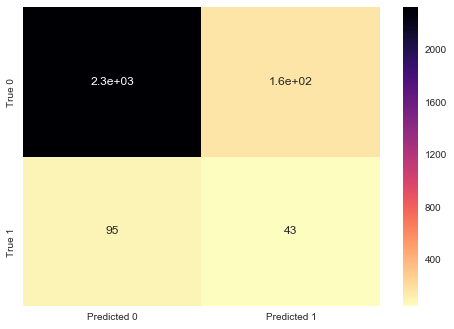

In [135]:
#plotting best model results
y_hat = best.predict(X_test)

print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

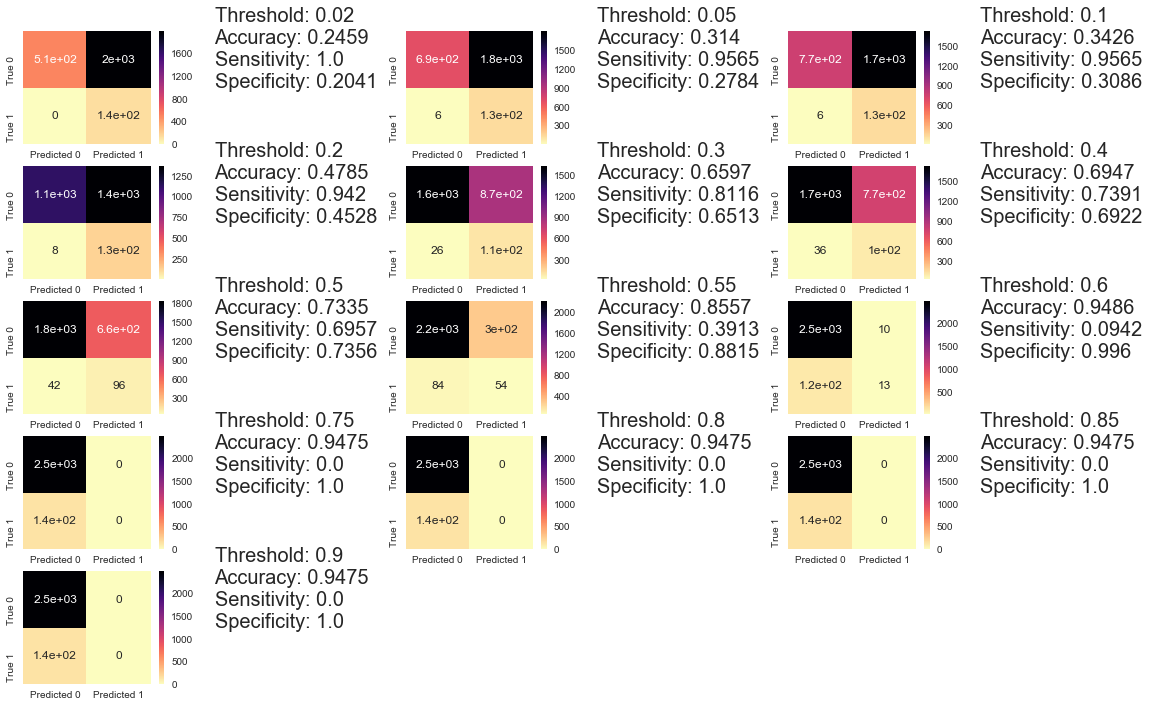

In [45]:
#plotting best model results with various thresholds for determining class 0 or 1

#thresholds = [0.02,0.05,0.1, 0.2, 0.5, 0.8]
thresholds = [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.75, 0.8, 0.85, 0.9]

fig = plt.figure(figsize=(20, 12))

for i, threshold in enumerate(thresholds):
    pred = best.predict_proba(X_test)
    y_test_hat = []
    for obs in range(len(pred)):
        if pred[obs][1] < threshold:
            y_test_hat.append(0)
        else:
            y_test_hat.append(1)

    ax = fig.add_subplot(5, 6, i*2+1)
    conf_mat = confusion_matrix(y_test, y_test_hat)
    sns.heatmap(conf_mat, annot=True, cmap='magma_r', 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);
    
    ax = fig.add_subplot(5, 6, i*2+2)
    text = 'Threshold: '+str(threshold)+ '\n'
    text += 'Accuracy: '+str(round(accuracy_score(y_test, y_test_hat), 4))+ '\n'
    text += 'Sensitivity: '+ str(round(conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]), 4))+ '\n' # TP/(FN+TP)
    text += 'Specificity: '+str(round(conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]), 4)) # TN/(FP+TN)
    
    ax.text(x=0,y=0.5,s=text, fontsize=20)
    ax.axis('off')

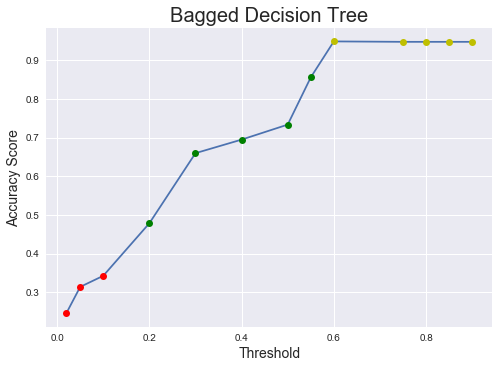

In [133]:
thresholds = [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.75, 0.8, 0.85, 0.9]
accuracy = [0.2459, 0.314, 0.3426, 0.4785, 0.6597, 0.6947, 0.7335, 0.8557, 0.9486, 0.9475, 0.9475, 0.9475, 0.9475]
plt.plot(thresholds, accuracy);
plt.title('Bagged Decision Tree', fontsize = 20)
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('Accuracy Score', fontsize = 14)

for i in range(len(thresholds)):
    if i < 3:
        plt.plot(thresholds[i], accuracy[i], 'ro')
    elif i < 8:
        plt.plot(thresholds[i], accuracy[i], 'go')
    else:
        plt.plot(thresholds[i], accuracy[i], 'yo')


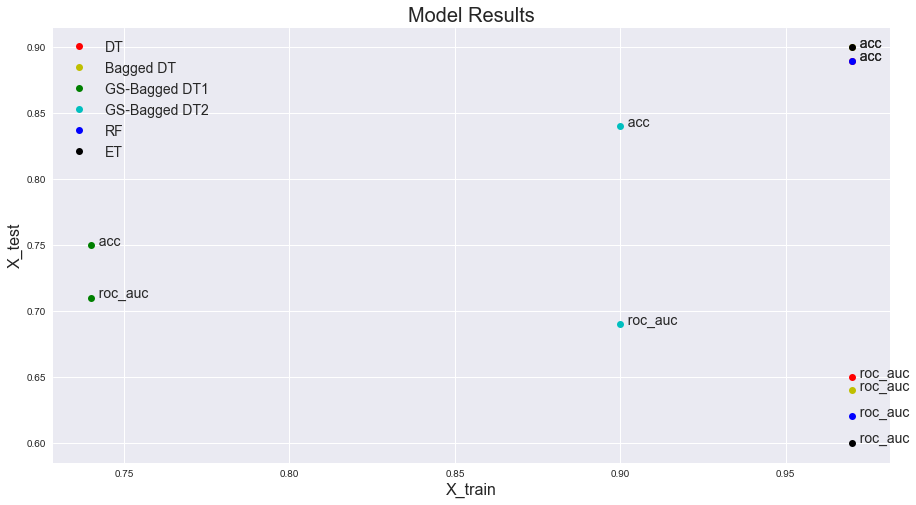

In [25]:
models = ['DT', 'Bagged DT', 'GS-Bagged DT1', 'GS-Bagged DT2', 'RF', 'ET']
#DT1: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 50}
#DT2: {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 2, 'n_estimators': 9}

acc_train = [0.97, 0.97, 0.74, 0.90, 0.97, 0.97]
acc_test = [0.89, 0.90, 0.75, 0.84, 0.89, 0.90]
roc_auc_train = [0.97, 0.97, 0.74, 0.90, 0.97, 0.97]
roc_auc_test = [0.65, 0.64, 0.71, 0.69, 0.62, 0.60]

colors = ['ro', 'yo', 'go', 'co', 'bo', 'ko']

plt.figure(figsize=(15,8))

for i in range(len(models)):    
    plt.plot(acc_train[i], acc_test[i], colors[i], label = models[i])
    plt.plot(roc_auc_train[i], roc_auc_test[i], colors[i])
    plt.text(acc_train[i], acc_test[i], s = '  acc', fontsize=14)
    plt.text(roc_auc_train[i], roc_auc_test[i], s = '  roc_auc', fontsize=14)
    plt.xlabel('X_train', fontsize = 16)
    plt.ylabel('X_test', fontsize = 16)
    plt.title('Model Results', fontsize = 20)
    plt.legend(fontsize = 14)

sns.set_style('darkgrid')

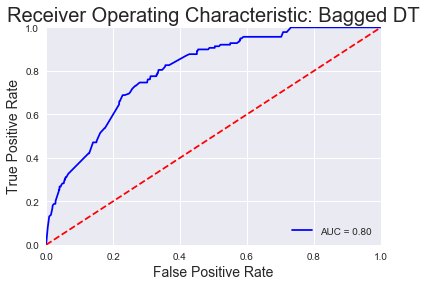

In [24]:
probs = best.predict_proba(X_test)
preds = probs[:,1]
x, y, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(x, y)

plt.title('Receiver Operating Characteristic: Bagged DT', fontsize = 20)
plt.plot(x, y, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.show()

# Comparison

In [48]:
#comparing against balanced class - baseline
baseline = y_train['WnvPresent'].value_counts()[1] / len(y_train['WnvPresent'])
print('baseline_acc:', baseline)

baseline_acc: 0.33329102678004824


In [49]:
#comparing against LogReg model

lr = LogisticRegression()
lr.fit(X_train, y_train)
print('train_acc:', lr.score(X_train, y_train['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_train['WnvPresent'], lr.predict(X_train)))
print('test_acc:', lr.score(X_test, y_test['WnvPresent']), 'roc_auc_score:', roc_auc_score(y_test['WnvPresent'], lr.predict(X_test)))    #overfit


train_acc: 0.750729788044168 roc_auc_score: 0.7086981377485815
test_acc: 0.8313665778454511 roc_auc_score: 0.6919809480555023


Confusion matrix:


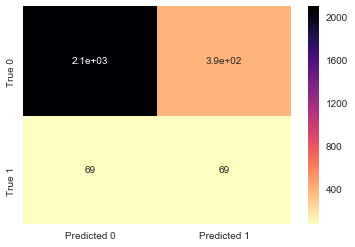

In [45]:
#plotting LogReg results
y_hat = lr.predict(X_test)

print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

In [52]:
#comparing against kNN model
neighbors = [1, 3, 5, 7, 9, 11, 15, 18, 20]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    print(i)
    print('train_acc:' , knn.score(X_train, y_train), 'roc_auc:', roc_auc_score(y_train['WnvPresent'], knn.predict(X_train)))
    print('test_acc:' , knn.score(X_test, y_test), 'roc_auc:', roc_auc_score(y_test['WnvPresent'], knn.predict(X_test)))
    print('')

1
train_acc: 0.9173753014341921 roc_auc: 0.8774755193746322
test_acc: 0.9078797106966121 roc_auc: 0.5612433839327824

3
train_acc: 0.9114100774209926 roc_auc: 0.8917602156472731
test_acc: 0.8732394366197183 roc_auc: 0.6079867358405973

5
train_acc: 0.892879807082117 roc_auc: 0.8839574716598312
test_acc: 0.8545869813475447 roc_auc: 0.6837010381912297

7
train_acc: 0.8763802513009266 roc_auc: 0.8753923881163762
test_acc: 0.8271792919680243 roc_auc: 0.6760820072085291

9
train_acc: 0.8573423023226298 roc_auc: 0.8561633949714876
test_acc: 0.8138561096307575 roc_auc: 0.672473375606291

11
train_acc: 0.8452849346363752 roc_auc: 0.8431217050888413
test_acc: 0.8070041872858774 roc_auc: 0.6757020746356432

15
train_acc: 0.8232009138215509 roc_auc: 0.8135146071827234
test_acc: 0.8104301484583175 roc_auc: 0.6740877251209672

18
train_acc: 0.8226932351821297 roc_auc: 0.8030405575372809
test_acc: 0.8378378378378378 roc_auc: 0.6885513651370379

20
train_acc: 0.8160934128696535 roc_auc: 0.79123516841

In [70]:
X_train.columns

Index(['Longitude', 'Latitude', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'DaysFromSpray', 'LogDays', 'SprayEffect',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'VCTS', 'TS', 'TSRA', 'BR', 'RA', 'SQ',
       'MIFG', 'VCFG', 'HZ', 'BCFG', 'DZ', 'GR', 'FU', 'FG+', 'FG'],
      dtype='object')

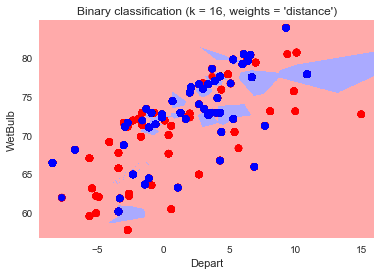

In [76]:
#plotting kNN
n_neighbors = 16

# import some data to play with
X = X_train.loc[:, ['Depart', 'Tavg']]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = y_train['WnvPresent']

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold)#, label = y_train['WnvPresent'])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Binary classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    plt.xlabel('Depart')
    plt.ylabel('WetBulb')

#plt.legend()
plt.show()

# Save model results for submission

In [50]:
#drop Type: unspecified mosquito species + additional weather codesum fields that appear in train but not test set

test = test.drop(['Species_UNSPECIFIED CULEX'], axis = 1)
X_train, test = X_train.align(test, join='outer', axis=1, fill_value=0)
print(X_train.shape, X_test.shape, test.shape)

In [52]:
#predict target WnvPresent in test_merge_all.csv
y_pred = best.predict(test)
pd.Series(y_pred).value_counts()


1    116293
dtype: int64

In [53]:
#input target values to sample submission format + save to_csv

#test['WnvPresent'].value_counts()
test['WnvPresent'] = y_pred
test = test.loc[:, ['WnvPresent']]
test.index += 1    #reset index to start at 1
test.index.names = ['Id']

test.to_csv('sample1hc.csv')